In [74]:
import sys
import os
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torcheval.metrics import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassRecall,
    MulticlassPrecision,
    MulticlassConfusionMatrix,
)

In [75]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            3, 6, 5
        )  # (3, 256, 256) -> new dim (256 - 5 + (2 * 0)) / 1 + 1 ) = 252 (6, 252, 252)
        self.pool = nn.MaxPool2d(2, 2)  # (6, 252, 252) -> (6, 126, 126)
        self.conv2 = nn.Conv2d(
            6, 16, 5
        )  # (6, 126, 126) -> (16, 122, 122) -> MaxPool -> (16, 61, 61)
        # self.fc1 = nn.Linear(16 * 61 * 61, 2048)
        self.fc1 = nn.Linear(16 * 13 * 13, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [76]:
def create_dataloaders(dataset):
    # data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    data_loader = DataLoader(dataset, shuffle=True)
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    # print(images, labels)
    print(dataset.classes)
    # imshow(torchvision.utils.make_grid(images))
    labels = np.array([dataset.targets[i] for i in range(len(dataset))])

    # Define split sizes
    train_size = 0.7  # 70% for training
    val_size = 0.15  # 15% for validation
    test_size = 0.15  # 15% for testing

    # First, split into train + temp (val + test)
    train_idx, temp_idx, _, temp_labels = train_test_split(
        np.arange(len(dataset)),
        labels,
        stratify=labels,
        test_size=(1 - train_size),
        random_state=42,
    )

    # Then, split temp into validation and test
    val_idx, test_idx = train_test_split(
        temp_idx,
        stratify=temp_labels,
        test_size=(test_size / (test_size + val_size)),
        random_state=42,
    )

    # Create samplers
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Create DataLoaders
    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)
    # test_loader = DataLoader(dataset, batch_size=32, sampler=test_sampler)
    test_loader = DataLoader(dataset, sampler=test_sampler)
    return train_loader, val_loader, test_loader


def load_dataset(directory_path):
    transform = transforms.Compose(
        [
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    dataset = torchvision.datasets.ImageFolder(root=directory_path, transform=transform)
    return dataset

In [77]:
dataset = load_dataset("~/sgoinfre/leaves/images/Apple")
train_loader, val_loader, test_loader = create_dataloaders(dataset)

['Apple_Black_rot', 'Apple_healthy', 'Apple_rust', 'Apple_scab']


In [78]:
def compute_validation_metrics(net, validation_loader):
    net.eval()
    criterion = nn.CrossEntropyLoss()

    validation_metrics = {"loss": 0}
    with torch.no_grad():
        f1_score = MulticlassF1Score(num_classes=4, average="macro")
        for inputs, labels in validation_loader:
            outputs = net(inputs)
            preds = torch.argmax(outputs, dim=1)

            loss = criterion(outputs, labels)
            validation_metrics["loss"] += loss.item()
            f1_score.update(preds, labels)
    validation_metrics["loss"] /= len(validation_loader)
    validation_metrics["f1_score"] = f1_score.compute()
    net.train()
    return validation_metrics


def update_validation_metrics_history(
    net, validation_loader, validation_metrics_history
):
    new_validation_metrics = compute_validation_metrics(net, validation_loader)
    for name, value in new_validation_metrics.items():
        validation_metrics_history[name].append(value)

In [79]:
def early_stop(state_dict, validation_loss, best_loss=None, counter=0, patience=5, min_delta=0):
    if best_loss is None:
        best_loss = validation_loss
    elif validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            torch.save(state_dict, "best_model.pth")
            return True, best_loss, counter
    return False, best_loss, counter


In [80]:
def train_model(train_loader, validation_loader):
    net = CNN()
    criterion = nn.CrossEntropyLoss()
    best_loss = None
    counter = 0
    patience = 10
    optimizer = optim.AdamW(net.parameters(), lr=0.001)
    validation_metrics_history = {"f1_score": [], "loss": [], "accuracy": []}
    train_metrics_history = {"f1_score": [], "loss": [], "accuracy": []}
    for epoch in range(100):

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            print(i)
        train_metrics_history["loss"].append(running_loss / len(train_loader))
        
        update_validation_metrics_history(
            net, validation_loader, validation_metrics_history
        )
        print(validation_metrics_history)
        print(best_loss)
        state_dict = net.state_dict()
        stop, best_loss, counter = early_stop(
            state_dict,
            validation_metrics_history["loss"][-1],
            best_loss=best_loss,
            counter=counter,
            patience=patience,
        )
        if stop:
            return validation_metrics_history, train_metrics_history
        print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
    torch.save(net.state_dict(), "best_model.pth")
    return validation_metrics_history, train_metrics_history

In [81]:
validation_history, train_history = train_model(train_loader, val_loader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
{'f1_score': [tensor(0.7884)], 'loss': [0.48042532602945964], 'accuracy': []}
None
[1,    70] loss: 0.025
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
{'f1_score': [tensor(0.7884), tensor(0.8907)], 'loss': [0.48042532602945964, 0.27667589286963146], 'accuracy': []}
0.48042532602945964
[2,    70] loss: 0.013
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
{'f1_score': [tensor(0.7884), tensor(0.8907), tensor(0.8675)], 'loss': [0.48042532602945964, 0.27667589286963146, 0.2859659108022849], '

[0.48042532602945964, 0.27667589286963146, 0.2859659108022849, 0.16665057986974716, 0.1388396327694257, 0.11344147796432177, 0.16908277198672295, 0.14180493143697578, 0.17056819374362628, 0.1617612869789203, 0.18159069567918779, 0.21889102943241595, 0.13119686502031983, 0.1156491916316251, 0.15137583045288922, 0.21262791013966004]


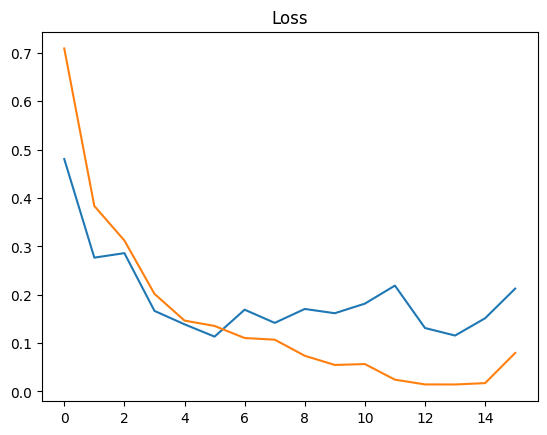

In [82]:
print(validation_history['loss'])

plot = plt.figure()
plt.plot(validation_history['loss'])
plt.plot(train_history['loss'])
plt.title('Loss')
plt.show()

In [83]:
def test_model(net, test_loader, num_classes):
    net.eval()

    metrics = {
        "accuracy": MulticlassAccuracy(),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro"),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro"),
        "f1_score": MulticlassF1Score(num_classes=num_classes, average="macro"),
        "confusion_matrix": MulticlassConfusionMatrix(num_classes=num_classes),
    }

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = net(images)
            preds = torch.argmax(outputs, dim=1)

            for metric in metrics.values():
                metric.update(preds, labels)

    results = {name: metric.compute() for name, metric in metrics.items()}

    for name, value in results.items():
        print(f"Test {name.capitalize()}: {value}")
    disp = ConfusionMatrixDisplay(results['confusion_matrix'], display_labels=dataset.classes)
    disp.plot()
    plt.show()

Test Accuracy: 0.9285714030265808
Test Recall: 0.9375541806221008
Test Precision: 0.9193407297134399
Test F1_score: 0.9259509444236755
Test Confusion_matrix: tensor([[ 92.,   1.,   0.,   0.],
        [ 10., 228.,   0.,   9.],
        [  0.,   1.,  41.,   0.],
        [ 11.,   1.,   1.,  81.]])


AttributeError: 'torch.dtype' object has no attribute 'kind'

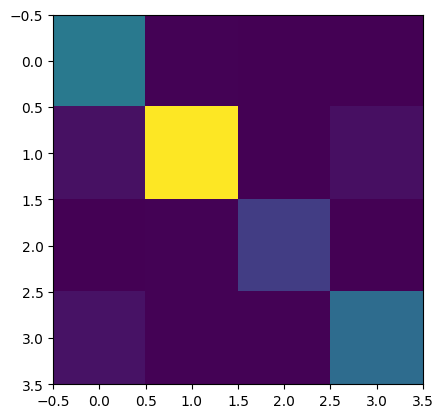

In [84]:
test_net = CNN()
test_net.load_state_dict(torch.load("best_model.pth", weights_only=True))
test_model(test_net, test_loader, len(dataset.classes))